In [1]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from PIL import Image
import base64
import io

In [2]:
EPOCHS = 15
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = '/kaggle/input/plantdisease'
width=256
height=256
depth=3

In [3]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [4]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Pepper__bell___Bacterial_spot ...
[INFO] Processing Potato___healthy ...
[INFO] Processing Tomato_Leaf_Mold ...
[INFO] Processing Tomato__Tomato_YellowLeaf__Curl_Virus ...
[INFO] Processing Tomato_Bacterial_spot ...
[INFO] Processing Tomato_Septoria_leaf_spot ...
[INFO] Processing Tomato_healthy ...
[INFO] Processing Tomato_Spider_mites_Two_spotted_spider_mite ...
[INFO] Processing Tomato_Early_blight ...
[INFO] Processing Tomato__Target_Spot ...
[INFO] Processing Pepper__bell___healthy ...
[INFO] Processing Potato___Late_blight ...
[INFO] Processing Tomato_Late_blight ...
[INFO] Processing Potato___Early_blight ...
[INFO] Processing Tomato__Tomato_mosaic_virus ...
[INFO] Processing PlantVillage ...
[INFO] Image loading completed


In [5]:
#Get Size of Processed Image
image_size = len(image_list)
print(image_size)

2952


In [6]:
#Transform Image Labels uisng Scikit Learn's LabelBinarizer
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)
#Print the classes
print(label_binarizer.classes_)

['Pepper__bell___Bacterial_spot' 'Pepper__bell___healthy'
 'Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy'
 'Tomato_Bacterial_spot' 'Tomato_Early_blight' 'Tomato_Late_blight'
 'Tomato_Leaf_Mold' 'Tomato_Septoria_leaf_spot'
 'Tomato_Spider_mites_Two_spotted_spider_mite' 'Tomato__Target_Spot'
 'Tomato__Tomato_YellowLeaf__Curl_Virus' 'Tomato__Tomato_mosaic_virus'
 'Tomato_healthy']


In [7]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [8]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] Spliting data to train, test


In [9]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [10]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

2021-11-15 06:44:16.608122: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-15 06:44:16.732043: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-15 06:44:16.732781: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-15 06:44:16.733941: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 85, 85, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 85, 85, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 85, 85, 64)        0

In [12]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [13]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2021-11-15 06:44:20.871541: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15


2021-11-15 06:44:23.008810: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


73/73 [==============================] - ETA: 0s - loss: 0.6156 - accuracy: 0.2258

2021-11-15 06:44:58.013399: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 464781312 exceeds 10% of free system memory.
2021-11-15 06:44:58.580317: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 464781312 exceeds 10% of free system memory.


73/73 [==============================] - 39s 430ms/step - loss: 0.6156 - accuracy: 0.2258 - val_loss: 0.5757 - val_accuracy: 0.0711
Epoch 2/15
73/73 [==============================] - 30s 405ms/step - loss: 0.2086 - accuracy: 0.4470 - val_loss: 0.5434 - val_accuracy: 0.0728
Epoch 3/15
73/73 [==============================] - 30s 404ms/step - loss: 0.1485 - accuracy: 0.5839 - val_loss: 1.4116 - val_accuracy: 0.0592
Epoch 4/15
73/73 [==============================] - 30s 406ms/step - loss: 0.1202 - accuracy: 0.6681 - val_loss: 0.8436 - val_accuracy: 0.1151
Epoch 5/15
73/73 [==============================] - 29s 402ms/step - loss: 0.1038 - accuracy: 0.7312 - val_loss: 0.5584 - val_accuracy: 0.1100
Epoch 6/15
73/73 [==============================] - 30s 404ms/step - loss: 0.1065 - accuracy: 0.7170 - val_loss: 2.6722 - val_accuracy: 0.1151
Epoch 7/15
73/73 [==============================] - 30s 404ms/step - loss: 0.1160 - accuracy: 0.6857 - val_loss: 0.4654 - val_accuracy: 0.2623
Epoch 8/15

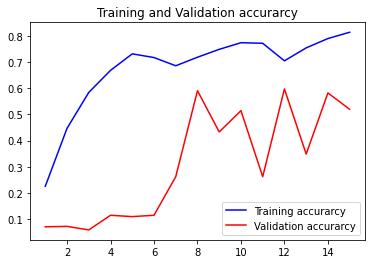

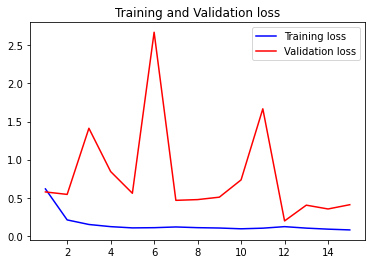

In [14]:
#Plot the train and val curve
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()


In [15]:
#Model Accuracy
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy


2021-11-15 06:53:16.121156: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 464781312 exceeds 10% of free system memory.
2021-11-15 06:53:16.619546: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 464781312 exceeds 10% of free system memory.


19/19 [==============================] - 0s 20ms/step - loss: 0.4081 - accuracy: 0.5195
Test Accuracy: 51.9458532333374


In [16]:
#  def convert_image(path):
#     image = Image.open(io.BytesIO(base64.b64decode(path)))
#     #image = cv2.imread(path)
#     try:
#         if image is not None :
#             image = image.resize(default_image_size, Image.ANTIALIAS)   
#             image_array = img_to_array(image)
#             return np.expand_dims(image_array, axis=0), None
#         else :
#             return None, "Error loading image file"
#     except Exception as e:
#         return None, str(e)
    
def prediction(path):
    image_array = convert_image_to_array(path)
    print(image_array)
    prediction = model.predict(np.expand_dims(image_array, axis = 0))
    print(prediction)
    return (label_binarizer.inverse_transform(prediction)[0])
    #[0,0,0,1.0.0]
    

In [17]:
path = '../input/plantdisease/PlantVillage/Pepper__bell___healthy/03e8ce3f-9bb5-481c-945b-1fa7d5da09e3___JR_HL 7583.JPG'
prediction(path)

[[[135. 127. 138.]
  [153. 145. 156.]
  [136. 128. 139.]
  ...
  [174. 167. 172.]
  [169. 162. 167.]
  [162. 155. 160.]]

 [[136. 128. 139.]
  [151. 143. 154.]
  [138. 130. 141.]
  ...
  [178. 171. 176.]
  [176. 169. 174.]
  [171. 164. 169.]]

 [[156. 148. 159.]
  [163. 155. 166.]
  [152. 144. 155.]
  ...
  [184. 177. 182.]
  [184. 177. 182.]
  [181. 174. 179.]]

 ...

 [[167. 153. 159.]
  [167. 153. 159.]
  [172. 158. 164.]
  ...
  [171. 154. 158.]
  [174. 157. 161.]
  [177. 160. 164.]]

 [[160. 146. 152.]
  [164. 150. 156.]
  [160. 146. 152.]
  ...
  [171. 154. 158.]
  [175. 158. 162.]
  [179. 162. 166.]]

 [[142. 128. 134.]
  [162. 148. 154.]
  [165. 151. 157.]
  ...
  [169. 152. 156.]
  [174. 157. 161.]
  [181. 164. 168.]]]
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


'Pepper__bell___healthy'